## Prepare Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
call_data = "../data/raw/call-center-data-v2-daily.csv"
df = pd.read_csv(call_data, parse_dates=["Date"])

print("Raw Talk Duration:")
print(df['Talk Duration (AVG)'].head(10))
print(f"Type: {df['Talk Duration (AVG)'].dtype}")

Raw Talk Duration:
0    0:02:29
1    0:02:06
2    0:01:35
3    0:01:50
4    0:02:10
5    0:02:18
6    0:01:40
7    0:02:10
8    0:02:03
9    0:01:49
Name: Talk Duration (AVG), dtype: object
Type: object


In [4]:
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

In [5]:
print("\nAfter set_index:")
print(f"df.index type: {type(df.index)}")
print(f"df.index dtype: {df.index.dtype}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few dates:")
print(df.index[:5])


After set_index:
df.index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
df.index dtype: datetime64[ns]
Date range: 2022-01-01 00:00:00 to 2025-05-31 00:00:00

First few dates:
DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05'],
              dtype='datetime64[ns]', name='Date', freq=None)


Data Validation

In [6]:
df['Calculated_Incoming_Calls'] = df['Answered Calls'] + df['Abandoned Calls']
df['Incoming_Match'] = df['Incoming Calls'] == df['Calculated_Incoming_Calls']
print(f"Data Valiation - All Incoming Calls Matches: {df['Incoming_Match'].all()}")
print(f"Mismatches: {(~df['Incoming_Match']).sum()}")

Data Valiation - All Incoming Calls Matches: True
Mismatches: 0


In [7]:
# Check date range
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total days: {len(df)}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# Check for date gaps
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = date_range.difference(df.index)
print(f"\nMissing dates: {len(missing_dates)}")
if len(missing_dates) > 0:
    print(missing_dates)

Date range: 2022-01-01 00:00:00 to 2025-05-31 00:00:00
Total days: 1247

Missing values:
Incoming Calls               0
Answered Calls               0
Abandoned Calls              0
Answer Speed (AVG)           0
Talk Duration (AVG)          0
Waiting Time (AVG)           0
Calculated_Incoming_Calls    0
Incoming_Match               0
dtype: int64

Missing dates: 0


In [8]:
# Print the missing date(s)
if len(missing_dates) > 0:
    print(f"Missing date(s):")
    for date in missing_dates:
        print(f"  {date.date()}")

Convert Time Columns 

In [9]:
print("Original Talk Duration values:")
print(df['Talk Duration (AVG)'].head(10))
print(f"\nData type: {df['Talk Duration (AVG)'].dtype}")

# Check a specific value
print(f"\nFirst value: {df['Talk Duration (AVG)'].iloc[0]}")
print(f"Type: {type(df['Talk Duration (AVG)'].iloc[0])}")

Original Talk Duration values:
Date
2022-01-01    0:02:29
2022-01-02    0:02:06
2022-01-03    0:01:35
2022-01-04    0:01:50
2022-01-05    0:02:10
2022-01-06    0:02:18
2022-01-07    0:01:40
2022-01-08    0:02:10
2022-01-09    0:02:03
2022-01-10    0:01:49
Name: Talk Duration (AVG), dtype: object

Data type: object

First value: 0:02:29
Type: <class 'str'>


In [10]:
# Convert time columns to total seconds
time_cols = ["Answer Speed (AVG)", "Talk Duration (AVG)", "Waiting Time (AVG)"]
for col in time_cols:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

print("\nTime columns converted to seconds:")
print(df[time_cols].head())
print(f"\nTalk Duration stats (seconds):\n{df['Talk Duration (AVG)'].describe()}")


Time columns converted to seconds:
            Answer Speed (AVG)  Talk Duration (AVG)  Waiting Time (AVG)
Date                                                                   
2022-01-01                15.0                149.0               192.0
2022-01-02                 3.0                126.0                35.0
2022-01-03                18.0                 95.0               157.0
2022-01-04                13.0                110.0               122.0
2022-01-05                10.0                130.0               202.0

Talk Duration stats (seconds):
count    1247.00
mean      157.60
std        23.72
min        57.00
25%       142.00
50%       157.00
75%       171.00
max       288.00
Name: Talk Duration (AVG), dtype: float64


Train/Test Split

In [11]:
# Define Splite Date
test_start = '2025-03-01'
test_end = '2025-05-31'

In [12]:
train = df[df.index < test_start]
test = df[(df.index >= test_start) & (df.index <= test_end)]

print(f"\nTrain set: {train.index.min()} to {train.index.max()} ({len(train)} days)")
print(f"Test set: {test.index.min()} to {test.index.max()} ({len(test)} days)")


Train set: 2022-01-01 00:00:00 to 2025-02-28 00:00:00 (1155 days)
Test set: 2025-03-01 00:00:00 to 2025-05-31 00:00:00 (92 days)


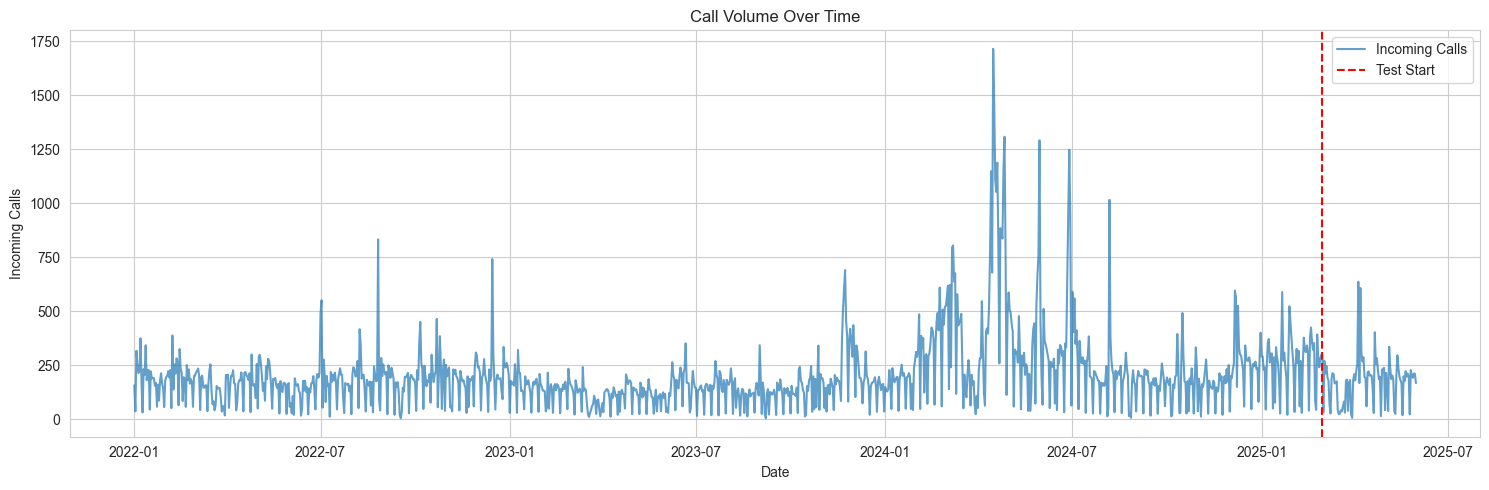

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Incoming Calls'], label='Incoming Calls', alpha=0.7)
plt.axvline(x=pd.to_datetime(test_start), color='r', linestyle='--', label='Test Start')
plt.xlabel('Date')
plt.ylabel('Incoming Calls')
plt.title('Call Volume Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import os
from pathlib import Path

# Get absolute path to the processed folder
notebook_dir = Path.cwd()
project_dir = notebook_dir.parent  # Go up one level from notebooks folder
output_dir = project_dir / 'data' / 'processed'

# Create the directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# Save the cleaned dataframe
output_file = output_dir / 'call_data_clean.csv'
df.to_csv(output_file, index=True)

print(f"✓ Cleaned data saved to:")
print(f"  {output_file}")
print(f"\nFile exists: {output_file.exists()}")
print(f"File size: {output_file.stat().st_size} bytes")

✓ Cleaned data saved to:
  /Users/jackiewang/Documents/GitHub/UCSD-Intuit-DS-Capstone-project-Jackie/data/processed/call_data_clean.csv

File exists: True
File size: 58292 bytes
